In [65]:
import pandas as pd
import numpy
import os
from datetime import datetime
from datetime import timedelta
%matplotlib notebook
import matplotlib.pyplot as plt
import pymultinest
import json
import corner
import warnings
from glob import glob




In [66]:
class simple_multinest():
    
    def __init__(self, x, y, model, parameters):
        
        self._x = x
        self._y = y
        self._model = model
        self._parameters = parameters
        
        #parameters is a dictionar with { 'par_name': {'min': val, 'max': val}}
    
    def create_uniform_prior(self, par_name):
        
        def uniform_transform(x):
            return self._parameters[par_name]['min']+ x * (self._parameters[par_name]['max']- self._parameters[par_name]['min'])
        
        self._parameters[par_name].update(transform = uniform_transform)
        self._parameters[par_name].update(aftertransform=lambda x: x)
        
    def make_all_uniform(self):
        
        for kk in self._parameters.keys():
            self.create_uniform_prior(kk)
    
    
    def test_statistics(self, par):
        
        #print(par)
        s = self._model(self._x, par)
    
        res = s - self._y + self._y * numpy.log( self._y / s)
    
        
        
        return 2 * numpy.sum(res)
    
    def log_likelihood(self, cube, ndim, nparams):
        
        par = {}
        for i, k in enumerate(self._parameters.keys()):
            t=self._parameters[k]
            par.update({k : t['aftertransform'](cube[i])})
        
        #print(par)
        return -0.5 * self.test_statistics(par)
    
    def create_prior_function(self):
        """
        Creates a single prior transformation function from parameters
        """

        def prior(cube, ndim, nparams):
                try:
                        for i, k in enumerate(self._parameters.keys()):
                                t=self._parameters[k]
                                transform = t['transform']
                                cube[i] = transform(cube[i])
                except Exception as e:
                        print('ERROR: Exception in prior function. Faulty transformations specified!')
                        print('ERROR:', e)
                        raise e

        return prior
    
    def nested_run(self, prior_function = None, sampling_efficiency = 0.3,
        n_live_points = 400, evidence_tolerance = 0.5,
        outputfiles_basename = 'nested-', verbose=True, clean=False, **kwargs):
        
        n_params = len(self._parameters)
        
        prior_function=self.create_prior_function()
        
        if clean:
            to_be_cleaned=glob(outputfiles_basename+'*')
            for ff in to_be_cleaned:
                os.remove(ff)
        
        pymultinest.run(self.log_likelihood, prior_function, n_params,
                sampling_efficiency = sampling_efficiency, n_live_points = n_live_points,
                outputfiles_basename = outputfiles_basename,
                verbose=verbose, **kwargs)
        
        paramnames = [str(k) for k in self._parameters.keys()]
        json.dump(paramnames, open('%s-params.json' % outputfiles_basename, 'w'), indent=4)
        
        
        self._analyzer = pymultinest.Analyzer(n_params = len(self._parameters),
                                                outputfiles_basename = outputfiles_basename)
        
        return outputfiles_basename

    def marginal_plots(self,minweight=1e-4, **kwargs):
        """
        Create marginal plots
        
        * analyzer: A instance of pymultinest.Analyzer
        * d: if more than 20 dimensions, by default only 1d marginal distributions
           are plotted. set d=2 if you want to force a 2d matrix plot
        
        """
        prefix = self._analyzer.outputfiles_basename
        parameters = json.load(open(prefix + '-params.json'))

        data = analyzer.get_data()[:,2:]
        weights = analyzer.get_data()[:,0]

        mask = weights > minweight
        
        
        with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                corner.corner(data[mask,:], weights=weights[mask],
                        labels=parameters, show_titles=True, **kwargs)

        plt.savefig(prefix + 'corner.pdf')
        
    def model_plot(self, nsample=100, xlabel='Days', ylabel='Poissonian variable', yscale='log', title='Title' ):
        
        posterior = self._analyzer.get_equal_weighted_posterior()
        print(len(posterior))
        if nsample > len(posterior):
            raise RuntimeError('Cannot plot more than sample')
        
        chosen = numpy.random.choice(numpy.arange(len(posterior)), replace=False, size=nsample)
        posterior = posterior[chosen,:]
        
        
        plt.figure()
        plt.errorbar(self._x, self._y, yerr=numpy.sqrt(self._y), marker='o', linestyle='')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.yscale(yscale)
        plt.title(title)
        
        xx=numpy.linspace(self._x.min(), self._x.max()+1, nsample)
        
        for k, row in enumerate(posterior):
            par = {}
            for i, k in enumerate(self._parameters.keys()):
                t=self._parameters[k]
                par.update({k : t['aftertransform'](row[i])})
            yy=self._model(xx, par)
            
            plt.plot(xx,yy, 'r-', alpha=0.5, linewidth=3)
        

In [76]:
data = pd.read_csv("https://raw.githubusercontent.com/daenuprobst/covid19-cases-switzerland/master/covid19_cases_switzerland.csv")
data

,Date,AG,AI,AR,BE,BL,BS,FR,GE,GL,...,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH,CH
0,2020-03-06,10.0,0.0,1.0,20.0,9.0,17.0,7.0,15,0.0,...,1.0,7.0,1.0,37.0,0.0,23,4.0,5.0,24.0,206
1,2020-03-07,14.0,0.0,1.0,25.0,13.0,22.0,7.0,24,0.0,...,1.0,7.0,1.0,43.0,0.0,30,5.0,6.0,28.0,261
2,2020-03-08,14.0,0.0,1.0,31.0,19.0,25.0,8.0,32,0.0,...,1.0,7.0,1.0,58.0,0.0,40,5.0,7.0,34.0,325
3,2020-03-09,14.0,0.0,2.0,34.0,20.0,29.0,10.0,33,0.0,...,1.0,7.0,2.0,67.0,0.0,51,7.0,7.0,36.0,365
4,2020-03-10,15.0,0.0,2.0,39.0,22.0,39.0,12.0,59,0.0,...,1.0,7.0,3.0,91.0,0.0,77,15.0,7.0,45.0,496
5,2020-03-11,17.0,0.0,2.0,41.0,23.0,49.0,16.0,66,2.0,...,3.0,8.0,4.0,131.0,0.0,108,18.0,7.0,55.0,626
6,2020-03-12,22.0,0.0,2.0,51.0,29.0,80.0,26.0,80,2.0,...,7.0,9.0,5.0,170.0,0.0,156,23.0,7.0,91.0,855
7,2020-03-13,28.0,0.0,5.0,62.0,42.0,111.0,31.0,104,4.0,...,8.0,10.0,5.0,218.0,2.0,222,29.0,7.0,140.0,1156
8,2020-03-14,31.0,2.0,5.0,78.0,48.0,119.0,38.0,196,5.0,...,10.0,13.0,5.0,262.0,2.0,273,47.0,9.0,148.0,1446
9,2020-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,281,NaN,...,NaN,13.0,NaN,NaN,NaN,406,NaN,NaN,NaN,2155


In [77]:
canton='CH'

data = data.filter(items=['Date', canton])  # only keep data for one canton (or whole CH) in dataframe
data.rename(columns={canton: "TotalPosTests1"}, inplace=True)
data = data.dropna()  # remove dates without available data (na)
newdata = data
startrow = 0
for x in data['TotalPosTests1']:
    if x == 0:
        startrow+=1
newdata = newdata.iloc[startrow:]
inhabitantsCH = 8570000.0
datearray = newdata['Date'].to_numpy()
for x in datearray:
    x = datetime.strptime(x, '%Y-%m-%d')
datetimearray = [datetime.strptime(x, '%Y-%m-%d').date() for x in datearray]
try:
    firstdate = datetimearray[1]
except IndexError:
    sys.exit('No cases in database for {}.'.format(canton))

datesincezero = [float((x - firstdate).days) + 1.0 for x in datetimearray]
poscasearray = newdata['TotalPosTests1'].to_numpy().tolist()
x = numpy.array(datesincezero)
y = numpy.array(poscasearray)

In [78]:
parameters = {
    'break' : {'min': 2., 'max' : 16.} , 
    't1' : {'min': -40, 'max' : 0.} , 
    't2' : {'min': -200, 'max' : 0.} ,  
    'b1'  : {'min': 0, 'max' : 2.} , 
    'b2' : {'min': 0, 'max' : 2.} 
}




def broken_pl(x, par):
    
    #print(par)
    
    break_value = par['break']
    t1  = par['t1']
    t2  = par['t2']
    b1  = par['b1']
    b2  = par['b2']
    
    ind = x > break_value
    
    
    
    y = numpy.exp(b1*(x-t1))
    
    if numpy.sum(ind) >0:
        y[ind]=numpy.exp(b2*(x[ind]-t2))
    
    return y

outputfiles_basename = 'nested-'+canton+'-'
my_multinest=simple_multinest(x, y, broken_pl, parameters)

my_multinest.make_all_uniform()

my_multinest.nested_run(outputfiles_basename = outputfiles_basename, clean=False)

    
    
    

  analysing data from nested-CH-.txt


'nested-CH-'

In [79]:

# analyse results
print('analysing results...')
analyzer = pymultinest.Analyzer(n_params = len(parameters),
        outputfiles_basename = outputfiles_basename)
s = analyzer.get_stats()
# store information in readable, hierarchical format
json.dump(s, open(outputfiles_basename + 'stats.json', 'w'), indent=4)

#   print out summary
print()
print()
print('Parameter estimation summary')
print('****************************')
print()
print(' %20s: median, 10%%, q90%% quantile' % ('parameter name'))
print(' ', '-'*20)
for t, m in zip(parameters.keys(), s['marginals']):
        print(' %20s: %.3f  %.3f %.3f ' % (t, m['median'], m['q10%'], m['q90%']))
print()
print()
print('Model evidence: ln(Z) = %.2f +- %.2f' % (s['global evidence'], s['global evidence error']))
print()


analysing results...
  analysing data from nested-CH-.txt


Parameter estimation summary
****************************

       parameter name: median, 10%, q90% quantile
  --------------------
                break: 13.526  13.131 13.908 
                   t1: -21.551  -21.898 -21.198 
                   t2: -69.406  -74.558 -64.547 
                   b1: 0.246  0.243 0.248 
                   b2: 0.105  0.099 0.111 


Model evidence: ln(Z) = -87.80 +- 0.13



1854


<IPython.core.display.Javascript object>


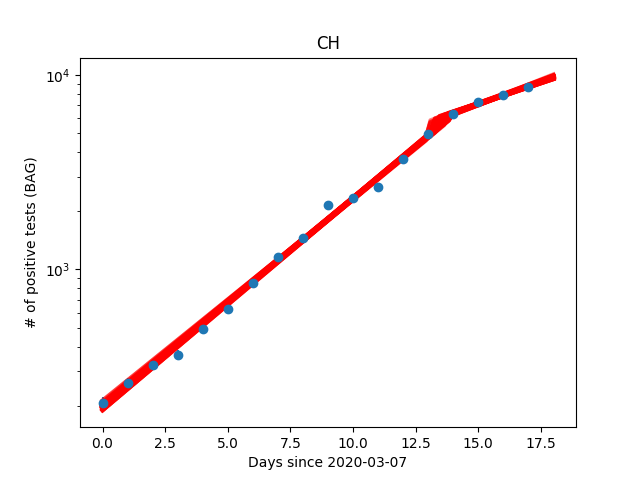

In [80]:
xlabel= "Days since %s"%firstdate.strftime('%Y-%m-%d')
ylabel= '# of positive tests (BAG)'
yscale='log'
my_multinest.model_plot(100, xlabel, ylabel, yscale, title=canton)



<IPython.core.display.Javascript object>


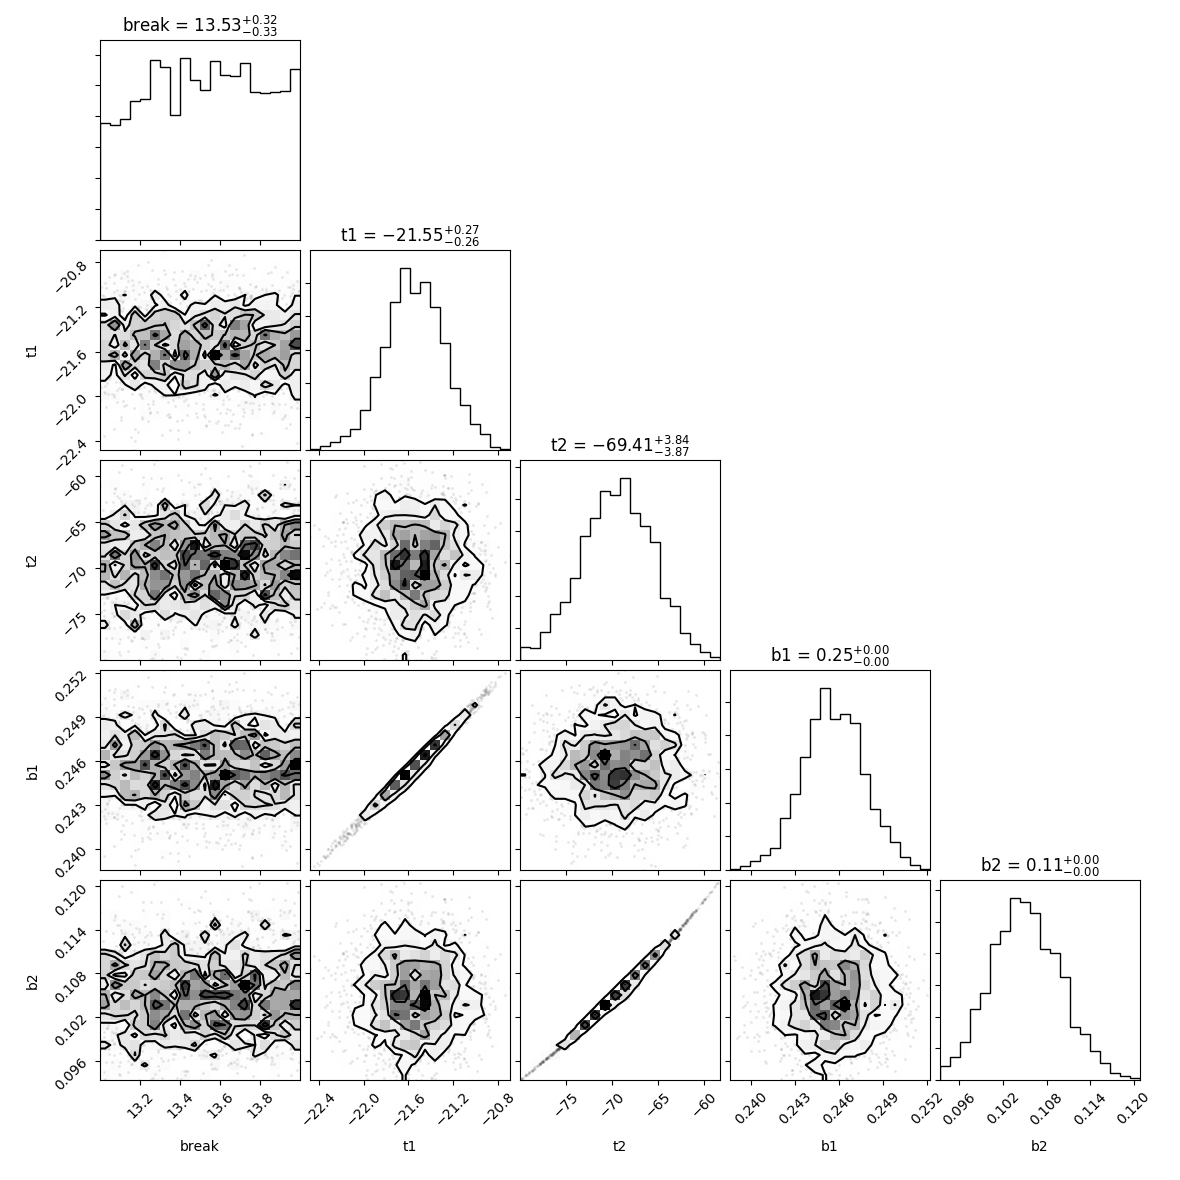

In [81]:
my_multinest.marginal_plots()